# TPs CVID

Auteur: charles.prioux - SCIA 2026

## TP 1. Motion estimation

In [1]:
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
from matplotlib import patches

In [2]:
def load_frame(path: str) -> np.ndarray:
    """
    Charge une image depuis le chemin donné et la convertit en niveaux de gris.
    """
    img = Image.open(path).convert('L')
    return np.array(img, dtype=np.float32)

frame1 = load_frame('1.png')
frame2 = load_frame('2.png')

### Implémentation de la méthode pixel wise

In [3]:
def pixel_wise(frame1 : np.ndarray, frame2: np.ndarray, search_radius : int = 8,
               skip_black_tiles : bool = False) -> np.ndarray:
  """
  Applique la méthode pixel-wise entre deux frames en admettant l’hypothèse de
  l’intensité constante. Le paramètre skip_black_tiles permet de ne pas prendre
  en compte les pixels noirs et ainsi d'accélérer le temps d'éxécution.
  Retourne une liste de vecteurs de mouvements.
  """
  h, w = frame1.shape
  vectors = np.zeros((h, w, 2), dtype=np.float32)

  for y in range(search_radius, h - search_radius):
    for x in range(search_radius, w - search_radius):
      ref_val = frame1[y, x]

      if skip_black_tiles and ref_val == 0:
        continue

      best_diff = float('inf') # Différence d'intensité minimale
      best_dist = float('inf') # Distance minimale
      best_dx = best_dy = 0

      for dy in range(-search_radius, search_radius + 1):
        y2 = y + dy
        if y2 < 0 or y2 >= h:
          continue

        for dx in range(-search_radius, search_radius + 1):
          x2 = x + dx
          if x2 < 0 or x2 >= w:
            continue

          diff = abs(ref_val - frame2[y2, x2])
          dist = dx * dx + dy * dy

          # On choisit le pixel avec l'intensité et la distance la plus proche
          # du pixel de référence
          if diff < best_diff or (diff == best_diff and dist < best_dist):
            best_diff = diff
            best_dist = dist
            best_dx = dx
            best_dy = dy

      vectors[y, x, 0] = best_dx
      vectors[y, x, 1] = best_dy

  return vectors

pixel_wise_vectors = pixel_wise(frame1, frame2, skip_black_tiles=True)

### Implémentation de la fonction de visualisation des vecteurs de mouvements

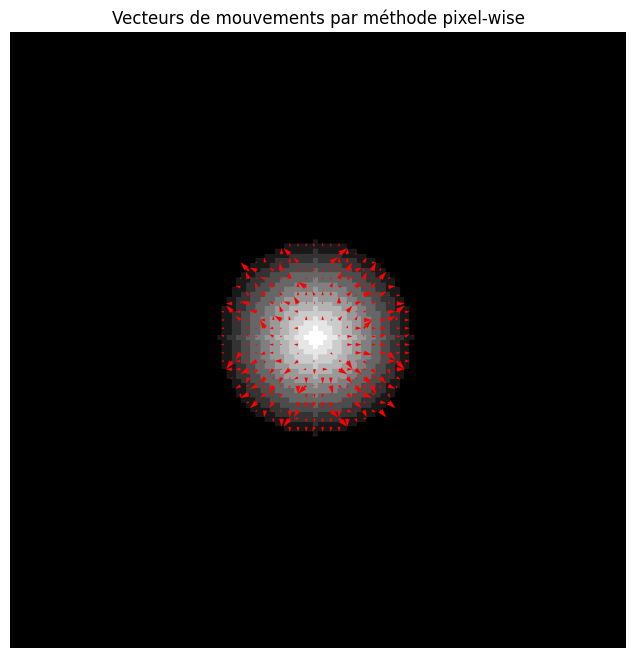

In [4]:
def visualize_motion_vectors(frame1: np.ndarray, vectors: np.ndarray,
                             step : int = 8,
                             block_size : int = 1,
                             title : str = "Vecteurs de mouvements") -> None:
  plt.figure(figsize=(12,8))
  plt.imshow(frame1, cmap='gray', origin='upper')

  h, w = vectors.shape[:2]
  for x in range(0, h, step):
    for y in range(0, w, step):
      dy = vectors[x, y, 0]
      dx = vectors[x, y, 1]
      if abs(dx) > 1 or abs(dy) > 1:
        y2 = y * block_size + block_size / 2
        x2 = x * block_size + block_size / 2
        plt.quiver(y * block_size, x * block_size,
                   dy, dx,
                   angles='xy', scale_units='xy',
                   scale=1, width=0.003,
                   color='red')

  plt.title(title)
  plt.axis('off')
  plt.show()

visualize_motion_vectors(frame1, pixel_wise_vectors,
                         title="Vecteurs de mouvements par méthode pixel-wise")

### Implémentation de la méthode block based

In [5]:
def bma(frame1 : np.ndarray, frame2: np.ndarray, search_radius : int = 8,
        block_size : int = 8) -> np.ndarray:
  """
  Applique la méthode block-based entre deux frames en admettant l’hypothèse de
  l’intensité constante.
  Retourne une liste de vecteurs de mouvements.
  """
  h, w = frame1.shape
  vectors = np.zeros((h, w, 2), dtype=np.float32)

  for y in range(block_size, h - block_size, block_size):
    for x in range(block_size, w - block_size, block_size):
      ref_block = frame1[y : y + block_size, x : x + block_size]

      best_diff = float('inf')
      best_dx = best_dy = 0

      for dy in range(-search_radius, search_radius + 1):
        y2 = y + dy
        if y2 < 0 or y2 >= h:
          continue
        for dx in range(-search_radius, search_radius + 1):
          x2 = x + dx
          if x2 < 0 or x2 >= w:
            continue

          block = frame2[y2 : y2 + block_size, x2 : x2 + block_size]
          diff = np.sum(np.abs(ref_block - block))

          if diff < best_diff:
            best_diff = diff
            best_dx = dx
            best_dy = dy

      if best_diff != 0:
        vectors[y // block_size, x // block_size, 0] = best_dx
        vectors[y // block_size, x // block_size, 1] = best_dy
      else:
        vectors[y // block_size, x // block_size, 0] = 0
        vectors[y // block_size, x // block_size, 1] = 0

  return vectors

block_size = 8
bma_vectors = bma(frame1, frame2, block_size=block_size)

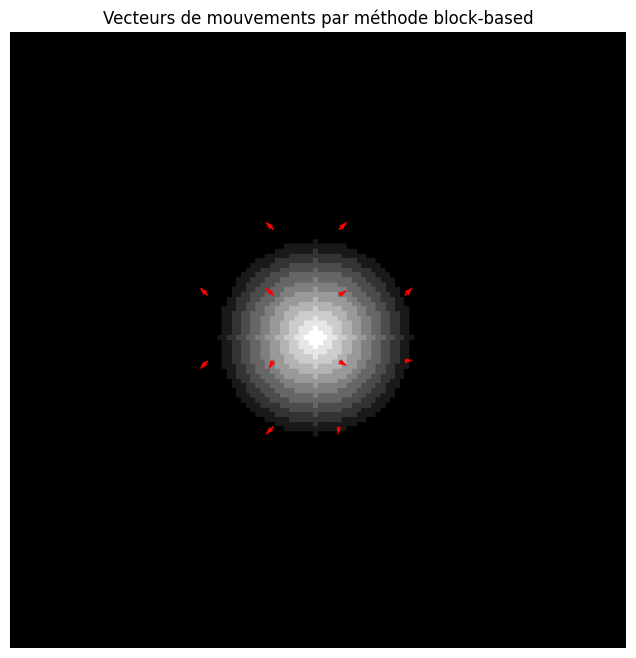

In [6]:
visualize_motion_vectors(frame1, bma_vectors, block_size=block_size,
                         title="Vecteurs de mouvements par méthode block-based")

### Analyse

_Que déduisez-vous des deux premières questions ? (régularité du champs de vecteurs de mouvement vs. taille des blocs)_

On peux en déduire deux hypothèses:
- La méthode pixel-wise offre une estimation **plus fine**, mais **plus bruitée**.
- La méthode block-based donne un champ **plus régulier**, **plus robuste** mais **moins précis** localement.

On conclue que le choix de la méthode se fait après un compromis entre précision locale et régularité globale dépendant principalement de la taille des blocs.


### Implémentation de la méthode de régularisation de Horn–Schunck

In [7]:
def horn_schunck(frame1: np.ndarray, frame2 : np.ndarray, alpha: float = 1.0,
                 num_iter: int = 100) -> np.ndarray:
  """
  Applique la méthode de régularisation de horn schunck entre deux frames en
  admettant l’hypothèse de l’intensité constante.
  Retourne une liste de vecteurs de mouvements.
  """
  h, w = frame1.shape
  vectors = np.zeros((h, w, 2), dtype=np.float32)

  u = np.zeros((h, w), dtype=np.float32)
  v = np.zeros((h, w), dtype=np.float32)

  # Calcul des dérivées spatiales et temporelles
  # np.gradient retourne [dI/dy, dI/dx]
  Iy, Ix = np.gradient(frame1.astype(np.float32))
  It = (frame2 - frame1).astype(np.float32)

  for _ in range(num_iter):
      # Moyenne sur les 4 voisins pour u et v
      u_avg = (
          np.roll(u,  1, axis=0) + np.roll(u, -1, axis=0) +
          np.roll(u,  1, axis=1) + np.roll(u, -1, axis=1)
      ) * 0.25
      v_avg = (
          np.roll(v,  1, axis=0) + np.roll(v, -1, axis=0) +
          np.roll(v,  1, axis=1) + np.roll(v, -1, axis=1)
      ) * 0.25

      denom = alpha**2 + Ix**2 + Iy**2 + 1e-12
      der = (Ix * u_avg + Iy * v_avg + It) / denom
      u = u_avg - Ix * der
      v = v_avg - Iy * der

  vectors = np.zeros((h, w, 2), dtype=np.float32)
  vectors[..., 0] = u  # dx
  vectors[..., 1] = v  # dy

  return vectors

horn_schunck_vectors = horn_schunck(frame1, frame2)

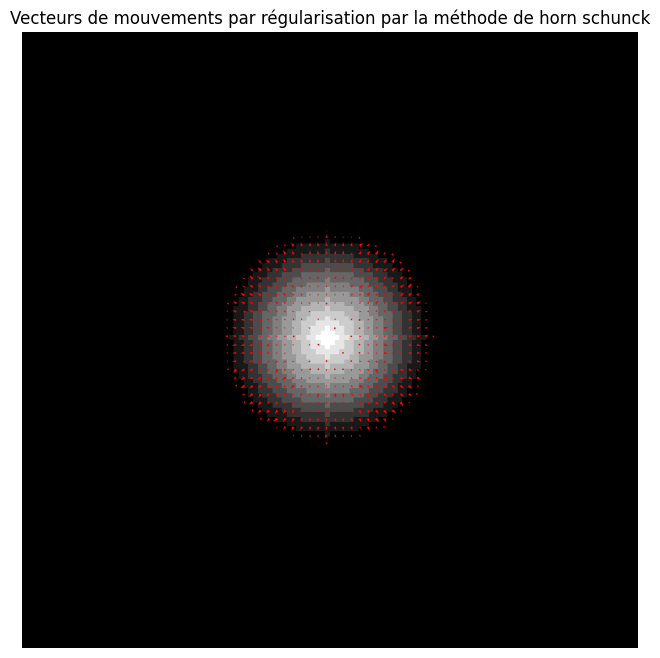

In [8]:
visualize_motion_vectors(frame1, horn_schunck_vectors,
                         title="Vecteurs de mouvements par régularisation par la méthode de horn schunck")

Testons désormais sur différente valeur de alpha:

In [9]:
alpha_values = [0.1, 1, 5, 10, 50]

vector_fields = {}

for alpha in alpha_values:
    vectors = horn_schunck(frame1, frame2, alpha=alpha, num_iter=100)
    vector_fields[alpha] = vectors

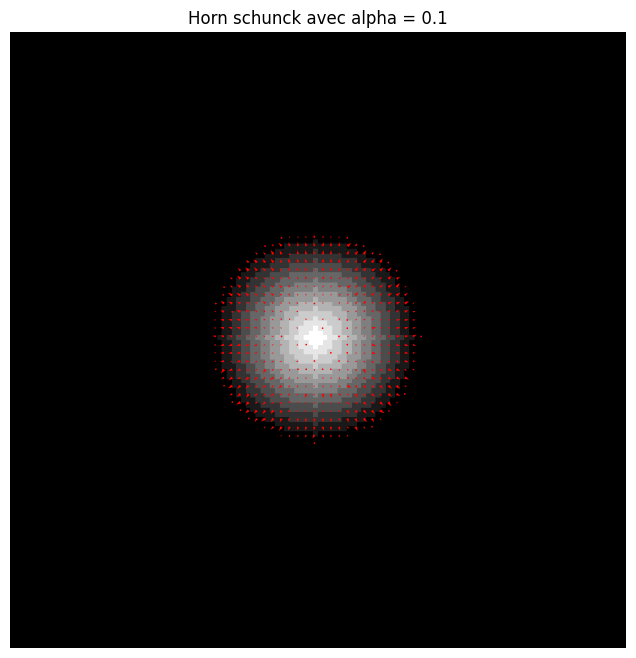

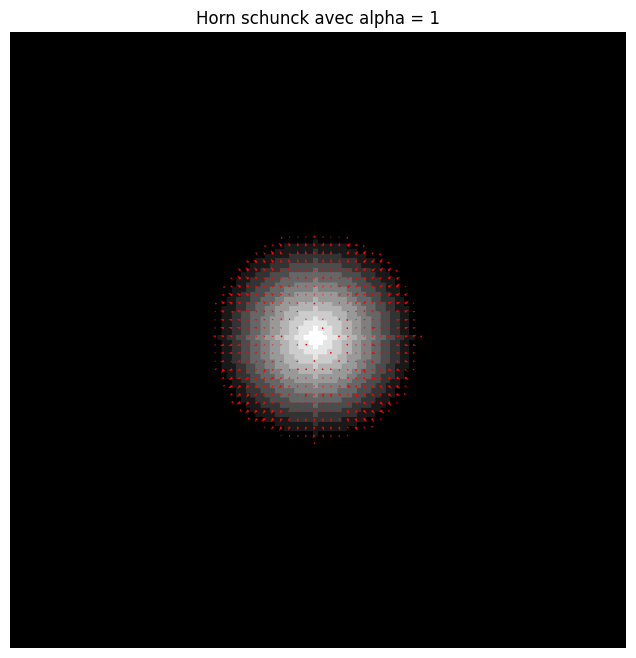

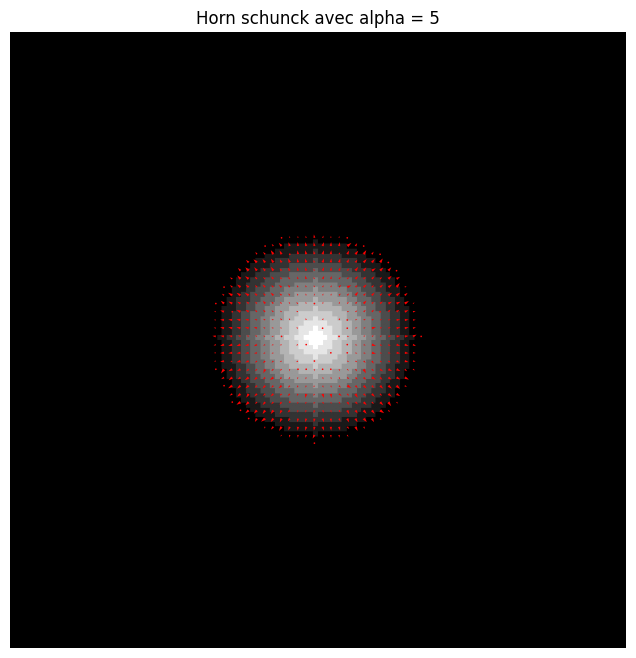

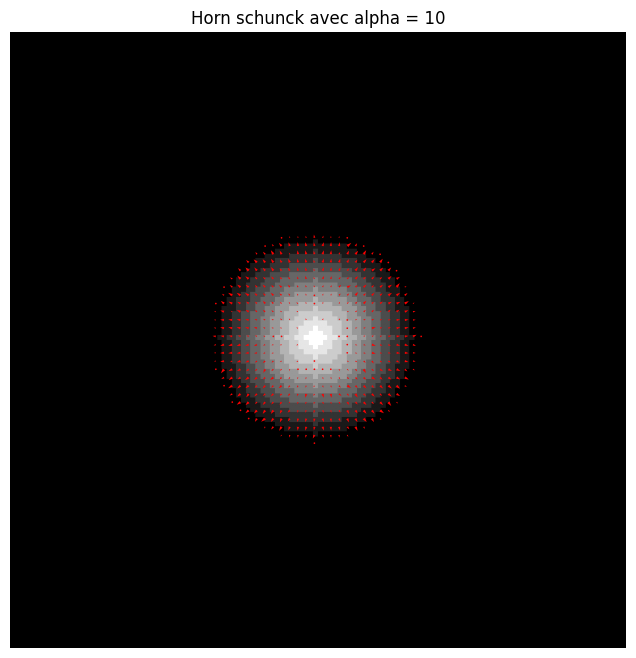

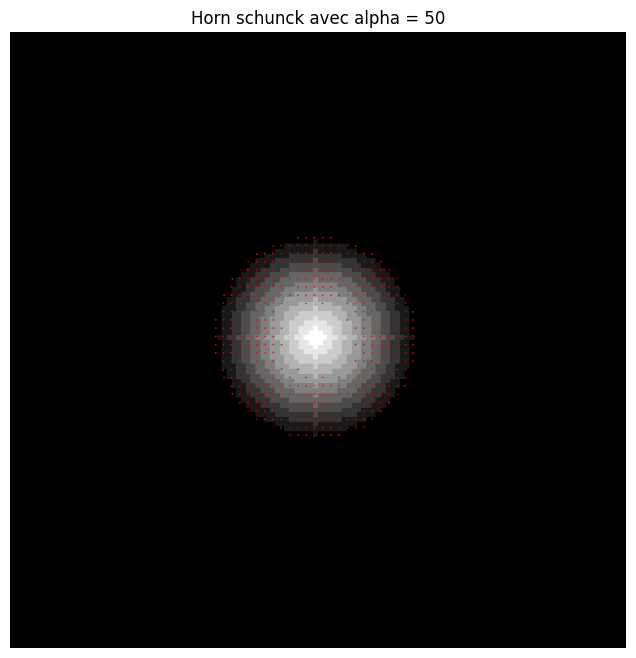

In [10]:
for i, alpha in enumerate(alpha_values):
  visualize_motion_vectors(frame1, vector_fields[alpha],
                         title="Horn schunck avec alpha = " + str(alpha))

_Discutez pour quelles valeurs de coefficients le champs de vecteurs obtenu semble plus correspondre au flot optique_

On distingue trois cas:
- **Faible alpha** (ex. 0.1) : peu de régularisation ⇒ le champ de vecteurs suit mieux les détails locaux mais peut être très bruité.

- **Fort alpha** (ex. 50) : régularisation forte ⇒ champ très lisse, mais les petits mouvements sont lissés voire perdus.

- **Valeurs intermédiaires** (1 à 10) : champ lisse et fidèle au mouvement.

Le alpha qui correspond le plus au flot optique semble être **1**.

## TP 2. Motion Compensation et Compression Vidéo

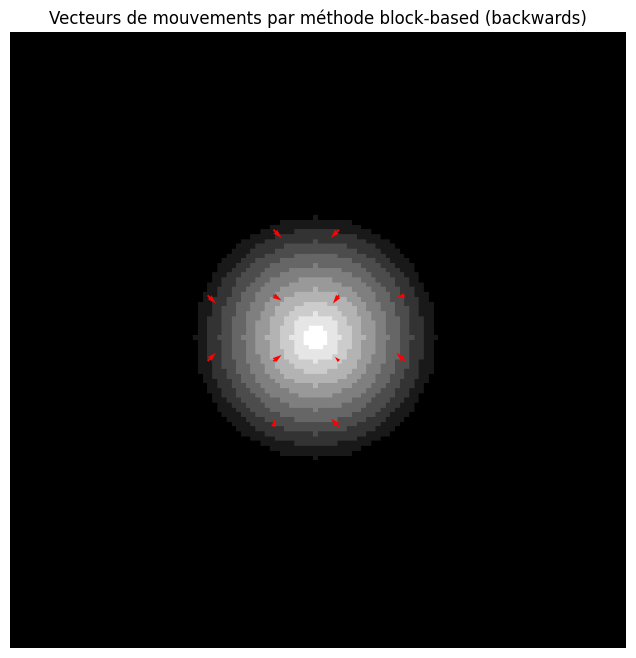

In [11]:
block_size = 8
bma_vectors = bma(frame2, frame1, block_size=block_size)

visualize_motion_vectors(frame2, bma_vectors, block_size=block_size,
                         title="Vecteurs de mouvements par méthode block-based (backwards)")

_Sachant que l’on va vouloir reconstruire la frame F2 à partir de F1,
pourquoi a-t-on donc fait de la ME backward et pas de la ME forward ? Que
se serait-il passé sinon ? (pensez à quels artéfacts visuels on aurait obtenu)_

On réalise la ME de manière backward, de F2 vers F1, car celà permet de s’assurer que chaque bloc de F2 trouve un équivalent dans F1. À l’inverse, une ME forward (de F1 vers F2) pourrait entraîner une situation où plusieurs blocs de F1 sont associés à un même bloc de F2, laissant ainsi certains blocs de F2 sans correspondance. Cela conduirait à une perte d’information (trous, chevauchements)

In [12]:
def frame_reconstructor(ref_frame: np.ndarray,
                                  motion_vectors: np.ndarray,
                                  block_size: int = 8) -> np.ndarray:
  H, W = frame1.shape[:2]
  F_pred = np.zeros_like(frame1, dtype=frame1.dtype)
  nb_h, nb_w = H // block_size, W // block_size

  for by in range(nb_h):
      for bx in range(nb_w):
          y0 = by * block_size
          x0 = bx * block_size

          dy, dx = motion_vectors[by, bx]
          dy_int = int(round(dy))
          dx_int = int(round(dx))

          # Compute source block coordinates and clip to valid range
          y_src = np.clip(y0 + dy_int, 0, H - block_size)
          x_src = np.clip(x0 + dx_int, 0, W - block_size)

          # Copy block from reference frame
          F_pred[y0 : y0 + block_size,
                  x0 : x0 + block_size] = (
                      frame1[y_src : y_src + block_size,
                            x_src : x_src + block_size]
                  )

  return F_pred

_frame2 = frame_reconstructor(frame1, bma_vectors)

In [13]:
def mse(frame1 : np.ndarray, frame2 : np.ndarray) -> np.float32:
    return np.square(np.mean(frame1 - frame2))

_mse = mse(frame2, _frame2)
print(f"MSE de reconstruction : {_mse}")

MSE de reconstruction : 17.013151168823242


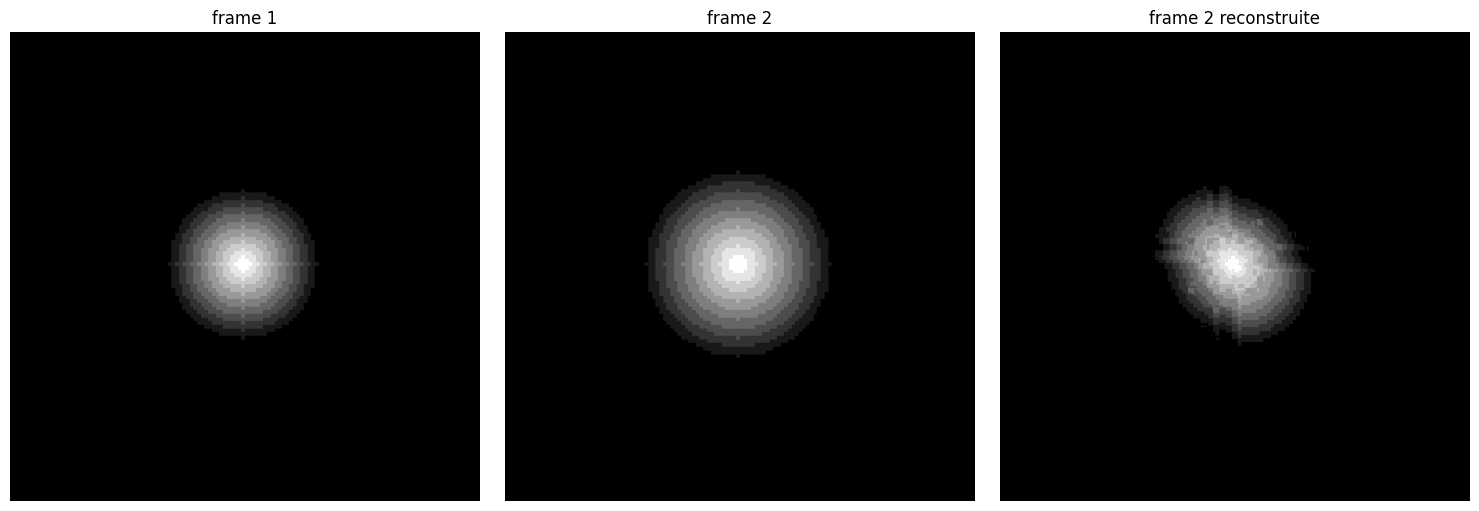

In [14]:
def compare_reconstruction(frame1 : np.ndarray, frame2 : np.ndarray,
                           _frame2 : np.ndarray) -> None :
  plt.figure(figsize=(15, 5))

  plt.subplot(1, 3, 1)
  plt.imshow(frame1, cmap='gray')
  plt.title("frame 1")
  plt.axis("off")

  plt.subplot(1, 3, 2)
  plt.imshow(frame2, cmap='gray')
  plt.title("frame 2")
  plt.axis("off")

  plt.subplot(1, 3, 3)
  plt.imshow(_frame2, cmap="gray")
  plt.title(f"frame 2 reconstruite")
  plt.axis("off")

  plt.tight_layout()
  plt.show()

compare_reconstruction(frame1, frame2, _frame2)

_Supposant que l’on n’aura plus accès à F2, quelles sont les 3 données
”classiques” (en plus du paramètres de taille de bloc) dont on a besoin pour la
reconstruire de façon parfaite en compensation de mouvement ?_

Les 3 donnéees dont on a besoin pour la reconstruction sont:
- **La frame de référence**
- **Les vecteurs de mouvements**
- **Le signal de correction**

In [15]:
def reconstruct_frame(frame1, motion_vectors, residuals, block_size):
    H, W = frame1.shape[:2]
    F_pred = np.zeros_like(frame1, dtype=frame1.dtype)
    nb_h, nb_w = H // block_size, W // block_size

    for by in range(nb_h):
        for bx in range(nb_w):
            y0, x0 = by * block_size, bx * block_size

            dy, dx = motion_vectors[by, bx]
            dy_int = int(round(dy))
            dx_int = int(round(dx))

            y_src = y0 + dy_int
            x_src = x0 + dx_int

            if y_src < 0:
                y_src = 0
            elif y_src > H - block_size:
                y_src = H - block_size

            if x_src < 0:
                x_src = 0
            elif x_src > W - block_size:
                x_src = W - block_size

            block_pred = frame1[
                y_src : y_src + block_size,
                x_src : x_src + block_size
            ]
            block_res = residuals[by, bx]

            F_pred[
                y0 : y0 + block_size,
                x0 : x0 + block_size
            ] = block_pred + block_res

    return F_pred

In [16]:
# Calcul des résidus par bloc
nb_h = frame1.shape[0] // block_size
nb_w = frame1.shape[1] // block_size
residuals = np.zeros((nb_h, nb_w, block_size, block_size), dtype=np.int16)

for by in range(nb_h):
    for bx in range(nb_w):
        y0, x0 = by * block_size, bx * block_size
        block_true = frame2[y0:y0+block_size, x0:x0+block_size].astype(np.int16)

        dy, dx = bma_vectors[by, bx]
        y_src = int(np.clip(y0 + dy, 0, frame1.shape[0] - block_size))
        x_src = int(np.clip(x0 + dx, 0, frame1.shape[1] - block_size))

        block_pred = frame1[y_src:y_src+block_size, x_src:x_src+block_size].astype(np.int16)

        residuals[by, bx] = block_true - block_pred

In [17]:
F2_recon = reconstruct_frame(frame1, bma_vectors, residuals, block_size)

mse_perfect = mse(frame2, F2_recon)
print(f"MSE de reconstruction parfaite : {mse_perfect}")

MSE de reconstruction parfaite : 0.0


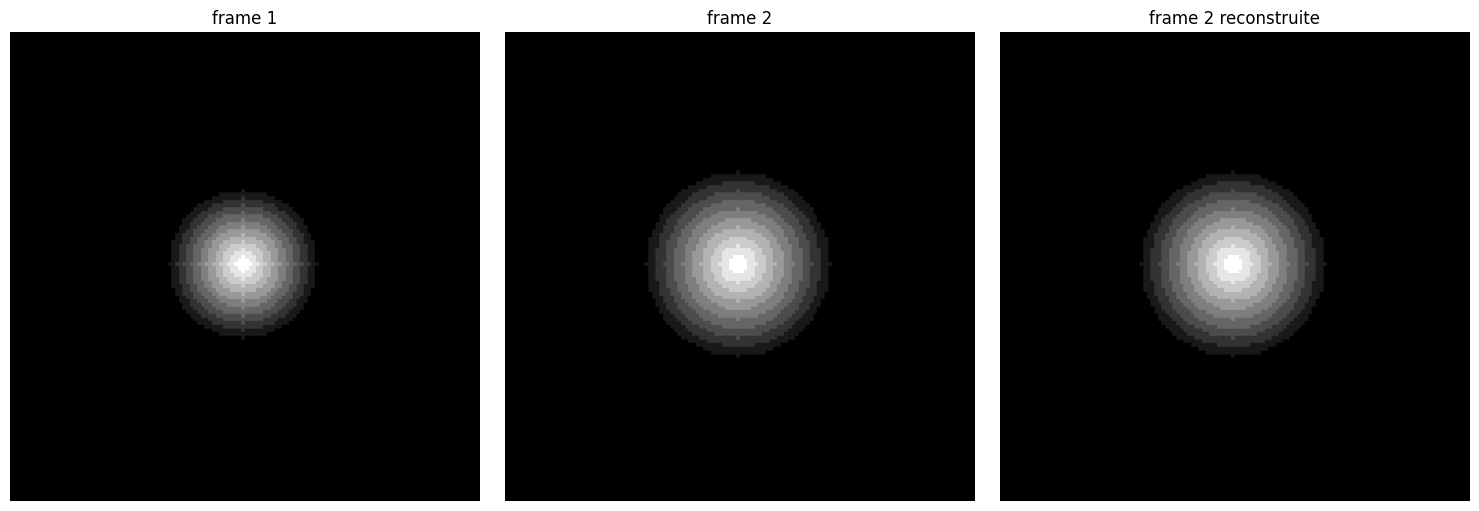

In [18]:
compare_reconstruction(frame1, frame2, F2_recon)

_Expliquez quelles données on peut coder avec perte pour garder une
qualité de reconstruction de F1 et F2 ”correcte”_

Les données sont:
- la frame de référence: cependant il faut que la perte soit relativement minime sinon celà se répecutera trop sur la frame reconstruite.
- les résidus

In [19]:
def quantize_frame(frame: np.ndarray, num_bits: int) -> np.ndarray:
    """
    Réduit la profondeur de bits d'une image entre 0 et 255.
    num_bits = 8  → pas de perte,
    num_bits = 4  → 16 niveaux, etc.
    """
    levels = 2 ** num_bits
    step = 256 // levels
    # on force uint8 pour éviter overflow
    return ((frame // step) * step).astype(np.uint8)

def quantize_residuals(residuals: np.ndarray, step: int) -> np.ndarray:
    """
    Quantifie les résidus en les arrondissant
    à l'entier multiple de 'step' le plus proche.
    """
    return ((residuals // step) * step).astype(residuals.dtype)

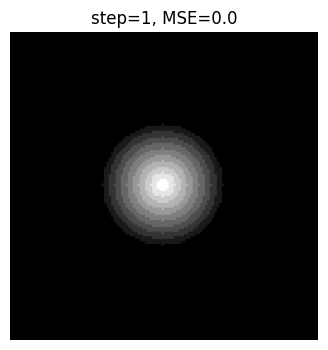

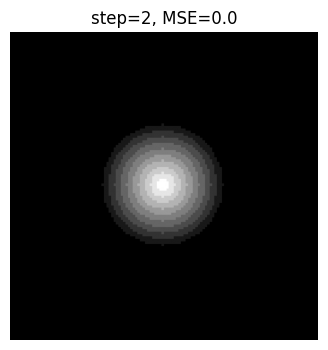

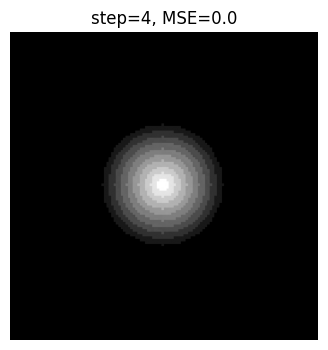

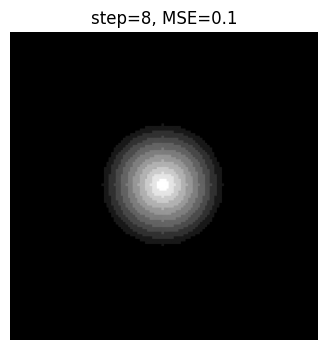

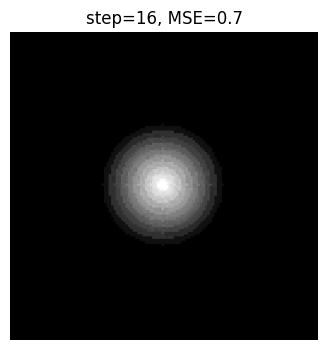

In [20]:
#Impact de la quantification des résidus seuls
for step in [1, 2, 4, 8, 16]:
    # quantification
    residuals_q = quantize_residuals(residuals, step)
    # reconstruction
    F2_qres = reconstruct_frame(frame1, bma_vectors, residuals_q, block_size)
    err = mse(frame2, F2_qres)
    # affichage
    plt.figure(figsize=(4,4))
    plt.title(f"step={step}, MSE={err:.1f}")
    plt.axis('off')
    plt.imshow(F2_qres, cmap='gray')
    plt.show()

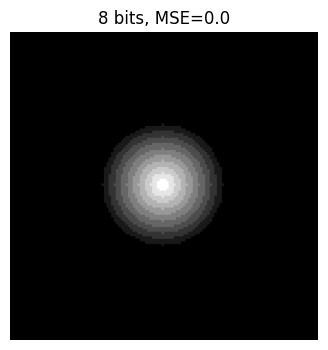

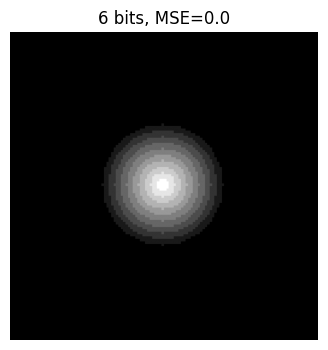

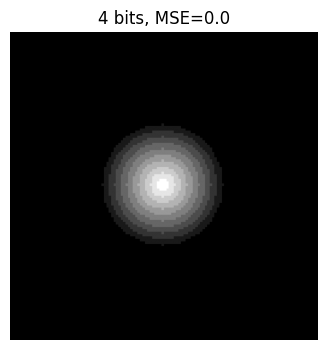

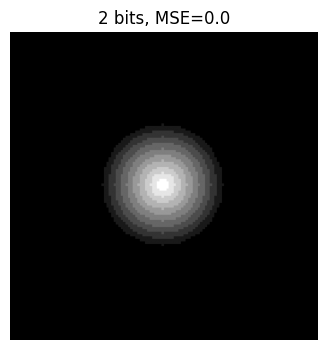

In [21]:
# Impact de la quantification de la frame de référence
for bits in [8, 6, 4, 2]:
    # quantification de la frame 1
    f1_q = quantize_frame(frame1, bits)
    # recalcul des résidus à partir de f1_q
    residuals_qf = np.zeros_like(residuals)
    for by in range(nb_h):
        for bx in range(nb_w):
            y0, x0 = by*block_size, bx*block_size
            # bloc « vrai »
            block_true = frame2[y0:y0+block_size, x0:x0+block_size].astype(np.int16)
            # prédiction
            dy, dx = bma_vectors[by, bx]
            y_src = int(np.clip(y0 + dy, 0, frame1.shape[0]-block_size))
            x_src = int(np.clip(x0 + dx, 0, frame1.shape[1]-block_size))
            block_pred = f1_q[y_src:y_src+block_size, x_src:x_src+block_size].astype(np.int16)
            residuals_qf[by, bx] = block_true - block_pred
    # reconstruction
    F2_qf = reconstruct_frame(f1_q, bma_vectors, residuals_qf, block_size)
    err = mse(frame2, F2_qf)
    # affichage
    plt.figure(figsize=(4,4))
    plt.title(f"{bits} bits, MSE={err:.1f}")
    plt.axis('off')
    plt.imshow(F2_qf, cmap='gray')
    plt.show()